<br>Name: Kaustubh Kothawale
<br>USC Id: 6553912638
<br>Email: kkothawa@usc.edu

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import random
import cv2
import os
from math import ceil
from shutil import copyfile
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.layers import Dropout, Dense, Input,Flatten,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Splitting the Data into Train Test and Validation

In [ ]:
#function to split data into train, validation and test
def split_data_train_val_test(data_dir,preprocessed_data_dir):
    # Loop through each folder in the input directory
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Load the images in the folder
        images = []
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            images.append(file_path)

        # Determine the number of images for each split
        n_images = len(images)
        train_frac = 0.7 * n_images
        val_frac = 0.15 * n_images
        test_frac = 0.15 * n_images
        n_train = ceil(train_frac)
        n_val = ceil(val_frac)
        n_test = n_images - n_train - n_val

        # Randomly select the images for each split
        random.shuffle(images)
        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]

        # Create the directories for each split
        for split, images in [('train', train_images), ('val', val_images), ('test', test_images)]:
            split_path = os.path.join(preprocessed_data_dir, split, folder)
            os.makedirs(split_path, exist_ok=True)

            # Copy the selected images to the split directory
            for i, image in enumerate(images):
                image_name = f"{i}.jpeg"
                output_path = os.path.join(split_path, image_name)
                copyfile(image, output_path)

In [ ]:
#Splitting the data into train, validation and test sets
data_dir="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Sport Images/"
preprocessed_data_dir="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Preprocessed Images/"
split_data_train_val_test(data_dir,preprocessed_data_dir)

# Performing Data Agumentation

In [ ]:
# Data Augmentation
data_agumentation = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
    )
train_data=data_agumentation.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Preprocessed Images/train",target_size=(224,224),batch_size=5)
test_data=ImageDataGenerator().flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Preprocessed Images/test",target_size=(224,224),shuffle=False)
val_data=ImageDataGenerator().flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Preprocessed Images/val",target_size=(224,224),shuffle=False)

Found 2298 images belonging to 5 classes.
Found 487 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


# Training and VGG 13 model and finding the test and train model evaluation metrics

In [ ]:
#vgg16 model
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(512, activation = 'relu')(vgg_x)
vgg_x=BatchNormalization()(vgg_x)
vgg_x=Dropout(0.2)(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

path="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/vgg-model-gpu.hdf5"
checkpoint=ModelCheckpoint(path,monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping=EarlyStopping(monitor='val_loss', patience=10,mode="min",start_from_epoch=50)

history = vgg16_final_model.fit(
  train_data,
  validation_data=val_data,
  epochs=100,
  callbacks=[early_stopping,checkpoint]
)

Epoch 1/100
460/460 [==============================] - ETA: 0s - loss: 1.4040 - accuracy: 0.4330
Epoch 1: val_accuracy improved from -inf to 0.64848, saving model to /content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/vgg-model-gpu.hdf5
460/460 [==============================] - 64s 135ms/step - loss: 1.4040 - accuracy: 0.4330 - val_loss: 0.9290 - val_accuracy: 0.6485
Epoch 2/100
460/460 [==============================] - ETA: 0s - loss: 1.0849 - accuracy: 0.6057
Epoch 2: val_accuracy improved from 0.64848 to 0.79596, saving model to /content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/vgg-model-gpu.hdf5
460/460 [==============================] - 56s 122ms/step - loss: 1.0849 - accuracy: 0.6057 - val_loss: 0.7447 - val_accuracy: 0.7960
Epoch 3/100
460/460 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 0.6558
Epoch 3: val_accuracy did not improve from 0.79596
460/460 [==============================] - 54s 117ms/step - loss: 0.9401 - accuracy: 0.

In [ ]:
vgg16_final_model.save_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/vgg-model-final.h5')

In [ ]:
predicted_classes=vgg16_final_model.predict(ImageDataGenerator().flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Preprocessed Images/train",target_size=(224,224),shuffle=False))
predicted_classes = np.argmax(predicted_classes, axis=1) 
print(predicted_classes)
from sklearn.metrics import classification_report
report = classification_report(train_data.classes, predicted_classes)
print(report)
print("Confusion Matrix VGG16 Train Data:\n", confusion_matrix(train_data.classes, predicted_classes))

Found 2298 images belonging to 5 classes.
72/72 [==============================] - 18s 248ms/step
[0 0 0 ... 4 4 4]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       515
           1       0.86      0.88      0.87       345
           2       0.93      0.82      0.87       444
           3       0.91      0.90      0.90       501
           4       0.91      0.87      0.89       493

    accuracy                           0.88      2298
   macro avg       0.89      0.88      0.88      2298
weighted avg       0.89      0.88      0.88      2298

Confusion Matrix VGG16 Train Data:
 [[486  13   5   7   4]
 [  7 303   9   5  21]
 [ 41   5 362  24  12]
 [ 32   9   4 451   5]
 [ 22  22   8  11 430]]


In [ ]:
predicted_classes=vgg16_final_model.predict(test_data)
predicted_classes = np.argmax(predicted_classes, axis=1) 
# print(predicted_classes)
from sklearn.metrics import classification_report
report = classification_report(test_data.classes, predicted_classes)
print(report)
print("Confusion Matrix VGG16 Test Data:\n", confusion_matrix(test_data.classes, predicted_classes))

16/16 [==============================] - 5s 328ms/step
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       109
           1       0.89      0.86      0.88        73
           2       0.91      0.80      0.85        94
           3       0.85      0.85      0.85       106
           4       0.91      0.85      0.88       105

    accuracy                           0.86       487
   macro avg       0.87      0.86      0.86       487
weighted avg       0.87      0.86      0.86       487

Confusion Matrix VGG16 Test Data:
 [[103   2   0   4   0]
 [  2  63   1   2   5]
 [ 11   1  75   6   1]
 [  7   3   3  90   3]
 [  7   2   3   4  89]]


<Figure size 640x480 with 0 Axes>

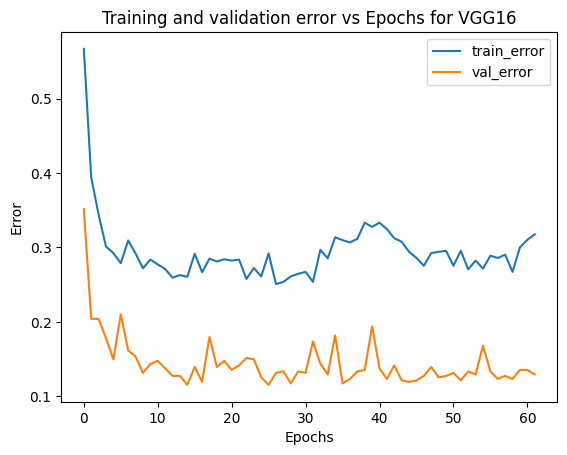

<Figure size 640x480 with 0 Axes>

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
error=[1 - x for x in acc]
val_error=[1 - x for x in val_acc]
epochs=range(len(acc)) 
plt.plot(epochs,error)
plt.plot(epochs,val_error)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(["train_error", 'val_error'])
plt.title('Training and validation error vs Epochs for VGG16')
plt.figure()

# Training and EfficientNetB0 model and finding the test and train model evaluation metrics

In [ ]:


effb0_model = EfficientNetB0(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in effb0_model.layers:
            layers.trainable=False
last_output = effb0_model.layers[-1].output
en0_x = Flatten()(last_output)
en0_x = Dense(64, activation = 'relu')(en0_x)
en0_x=BatchNormalization()(en0_x)
en0_x=Dropout(0.2)(en0_x)
en0_x = Dense(5, activation = 'softmax')(en0_x)
en0_final_model = Model(effb0_model.input, en0_x)
en0_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss', patience=5,mode="min",start_from_epoch=50)

history2 = en0_final_model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping]
)

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/66
460/460 [==============================] - 1320s 3s/step - loss: 0.7794 - accuracy: 0.7324 - val_loss: 0.2383 - val_accuracy: 0.9131
Epoch 2/66
460/460 [==============================] - 52s 114ms/step - loss: 0.5103 - accuracy: 0.8303 - val_loss: 0.2251 - val_accuracy: 0.9293
Epoch 3/66
460/460 [==============================] - 53s 115ms/step - loss: 0.4947 - accuracy: 0.8238 - val_loss: 0.2316 - val_accuracy: 0.9172
Epoch 4/66
460/460 [==============================] - 53s 114ms/step - loss: 0.4874 - accuracy: 0.8377 - val_loss: 0.2211 - val_accuracy: 0.9172
Epoch 5/66
460/460 [==============================] - 53s 115ms/step - loss: 0.4437 - accuracy: 0.8446 - val_loss: 0.1756 - val_accuracy: 0.9434
Epoch 6/66
460/460 [==============================] - 53s 115ms/step - loss: 0.4491 - accuracy: 0.8420 - val_loss: 0.2068 - val_accuracy: 0.9333
Epoch 7/66
460/460 [==============================] - 54s 117ms/st

In [ ]:
en0_final_model.save_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/enb0-model-final.h5')

In [ ]:
# en0_final_model.load_weights("./Models/enb0-model.hdf5")
predicted_classes=en0_final_model.predict(ImageDataGenerator().flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Preprocessed Images/train",target_size=(224,224),shuffle=False))
predicted_classes = np.argmax(predicted_classes, axis=1) 
print(predicted_classes)

report = classification_report(train_data.classes, predicted_classes)
print(report)

print("Confusion Matrix EfficientNetB0 Train Data:\n", confusion_matrix(train_data.classes, predicted_classes))

Found 2298 images belonging to 5 classes.
72/72 [==============================] - 15s 188ms/step
[0 0 0 ... 4 4 4]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       515
           1       0.99      0.99      0.99       345
           2       0.99      0.98      0.98       444
           3       1.00      0.98      0.99       501
           4       0.98      0.98      0.98       493

    accuracy                           0.99      2298
   macro avg       0.99      0.99      0.99      2298
weighted avg       0.99      0.99      0.99      2298

Confusion Matrix EfficientNetB0 Train Data:
 [[514   0   1   0   0]
 [  0 340   0   1   4]
 [  2   0 436   1   5]
 [  4   1   2 493   1]
 [  3   3   3   0 484]]


In [ ]:
predicted_classes=en0_final_model.predict(test_data)
predicted_classes = np.argmax(predicted_classes, axis=1) 
print(predicted_classes)
from sklearn.metrics import classification_report
report = classification_report(test_data.classes, predicted_classes)
print(report)
print("Confusion Matrix EfficientNetB0 Test Data:\n", confusion_matrix(test_data.classes, predicted_classes))

16/16 [==============================] - 261s 17s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 1 1
 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2
 4 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 2 2 2 2 3 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4
 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

<Figure size 640x480 with 0 Axes>

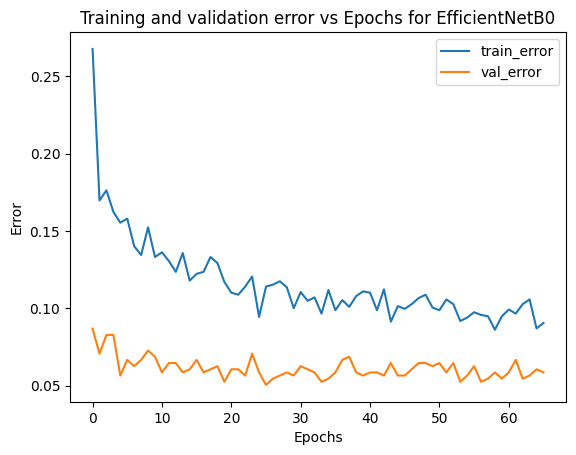

<Figure size 640x480 with 0 Axes>

In [ ]:
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
error=[1 - x for x in acc]
val_error=[1 - x for x in val_acc]
epochs=range(len(acc)) 
plt.plot(epochs,error)
plt.plot(epochs,val_error)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(["train_error", 'val_error'])
plt.title('Training and validation error vs Epochs for EfficientNetB0')
plt.figure()

# Training and ResNet50 model and finding the test and train model evaluation metrics

In [ ]:

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(5, activation='softmax'))
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='val_loss', patience=5,mode="min",start_from_epoch=50)
epochs=100
resnet_history = resnet_model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[early_stopping]
)

94765736/94765736 [==============================] - 0s 0us/step


Epoch 1/100
460/460 [==============================] - 541s 1s/step - loss: 0.9928 - accuracy: 0.6728 - val_loss: 0.6174 - val_accuracy: 0.8242
Epoch 2/100
460/460 [==============================] - 48s 104ms/step - loss: 0.7474 - accuracy: 0.7245 - val_loss: 0.4702 - val_accuracy: 0.8525
Epoch 3/100
460/460 [==============================] - 49s 106ms/step - loss: 0.6829 - accuracy: 0.7507 - val_loss: 0.3821 - val_accuracy: 0.8606
Epoch 4/100
460/460 [==============================] - 49s 107ms/step - loss: 0.6411 - accuracy: 0.7702 - val_loss: 0.4560 - val_accuracy: 0.8465
Epoch 5/100
460/460 [==============================] - 49s 107ms/step - loss: 0.6238 - accuracy: 0.7859 - val_loss: 0.3312 - val_accuracy: 0.8929
Epoch 6/100
460/460 [==============================] - 50s 108ms/step - loss: 0.6275 - accuracy: 0.7746 - val_loss: 0.3669 - val_accuracy: 0.8687
Epoch 7/100
460/460 [==============================] - 50s 108ms/step - loss: 0.5826 - accuracy: 0.7881 - val_loss: 0.3665 - v

In [ ]:
resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/resnet-model-final.h5")

In [ ]:
# en0_final_model.load_weights("./Models/enb0-model.hdf5")
predicted_classes=resnet_model.predict(ImageDataGenerator().flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Preprocessed Images/train",target_size=(224,224),shuffle=False))
predicted_classes = np.argmax(predicted_classes, axis=1) 
report = classification_report(train_data.classes, predicted_classes)
print(report)
print("Confusion Matrix EfficientNetB0 Train Data:\n", confusion_matrix(train_data.classes, predicted_classes))

Found 2298 images belonging to 5 classes.
72/72 [==============================] - 17s 230ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       515
           1       0.98      0.98      0.98       345
           2       0.97      0.97      0.97       444
           3       0.99      0.97      0.98       501
           4       0.97      0.97      0.97       493

    accuracy                           0.97      2298
   macro avg       0.98      0.97      0.97      2298
weighted avg       0.97      0.97      0.97      2298

Confusion Matrix EfficientNetB0 Train Data:
 [[509   0   2   1   3]
 [  0 338   1   2   4]
 [  6   0 430   0   8]
 [ 10   0   3 487   1]
 [  1   7   8   1 476]]


In [ ]:
predicted_classes=resnet_model.predict(test_data)
predicted_classes = np.argmax(predicted_classes, axis=1) 
report = classification_report(test_data.classes, predicted_classes)
print(report)
print("Confusion Matrix EfficientNetB0 Test Data:\n", confusion_matrix(test_data.classes, predicted_classes))

16/16 [==============================] - 86s 6s/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       109
           1       0.91      0.88      0.90        73
           2       0.91      0.91      0.91        94
           3       0.94      0.92      0.93       106
           4       0.85      0.92      0.89       105

    accuracy                           0.91       487
   macro avg       0.91      0.91      0.91       487
weighted avg       0.92      0.91      0.91       487

Confusion Matrix EfficientNetB0 Test Data:
 [[100   1   4   2   2]
 [  1  64   1   2   5]
 [  1   0  86   2   5]
 [  1   2   0  98   5]
 [  2   3   3   0  97]]


<Figure size 640x480 with 0 Axes>

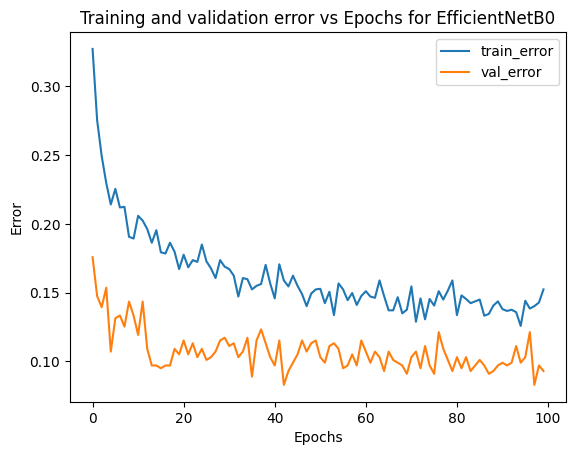

<Figure size 640x480 with 0 Axes>

In [ ]:
acc=resnet_history.history['accuracy']
val_acc=resnet_history.history['val_accuracy']
error=[1 - x for x in acc]
val_error=[1 - x for x in val_acc]
epochs=range(len(acc)) 
plt.plot(epochs,error)
plt.plot(epochs,val_error)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(["train_error", 'val_error'])
plt.title('Training and validation error vs Epochs for EfficientNetB0')
plt.figure()

# Training and EfficientNetB0 model On Entire Dataset 
Keeping the total number of epoch as the one it stoppied earlier with early stopping

In [ ]:
train_data=data_agumentation.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Sport Images/",target_size=(224,224),shuffle=True)
effb0_model = EfficientNetB0(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in effb0_model.layers:
            layers.trainable=False
last_output = effb0_model.layers[-1].output
en0_x = Flatten()(last_output)
en0_x = Dense(64, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(en0_x)
en0_x=BatchNormalization()(en0_x)
en0_x=Dropout(0.2)(en0_x)
en0_x = Dense(5, activation = 'softmax')(en0_x)
en0_final_model = Model(effb0_model.input, en0_x)
en0_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

path="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/eno-intrim-best.h5"
checkpoint=ModelCheckpoint(path,monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history2 = en0_final_model.fit(
    train_data,
    epochs=86,
    callbacks=[checkpoint]
)

Found 3262 images belonging to 5 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/100
102/102 [==============================] - 415s 4s/step - loss: 0.5961 - accuracy: 0.7906
Epoch 2/100
102/102 [==============================] - 71s 692ms/step - loss: 0.3233 - accuracy: 0.8869
Epoch 3/100
102/102 [==============================] - 71s 697ms/step - loss: 0.2645 - accuracy: 0.9074
Epoch 4/100
102/102 [==============================] - 71s 693ms/step - loss: 0.2696 - accuracy: 0.9065
Epoch 5/100
102/102 [==============================] - 70s 688ms/step - loss: 0.2316 - accuracy: 0.9197
Epoch 6/100
102/102 [==============================] - 70s 690ms/step - loss: 0.2354 - accuracy: 0.9194
Epoch 7/100
102/102 [==============================] - 70s 690ms/step - loss: 0.2054 - accuracy: 0.9267
Epoch 8/100
102/102 [==============================] - 71s 692ms/step - loss: 0.1994 - accuracy: 0.9344
Epoch 9/100
102/102 [==============================] - 70s 689m

In [ ]:
en0_final_model.save_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/full-data-model-final.h5')

# Training and ResNet50 model On Entire Dataset 
Keeping the total number of epoch as the one it stoppied earlier with early stopping

P.S. Please ignore the Validation Accuracy. The training dataset contains all the images, so validation accuracy does not make any sence.

In [ ]:
train_data=data_agumentation.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Sport Images/",target_size=(224,224),shuffle=True)
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(5, activation='softmax'))
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
epochs=80
resnet_history = resnet_model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Found 3262 images belonging to 5 classes.
94765736/94765736 [==============================] - 3s 0us/step


Epoch 1/80
102/102 [==============================] - 1093s 11s/step - loss: 1.5586 - accuracy: 0.7502 - val_loss: 1.2052 - val_accuracy: 0.8727
Epoch 2/80
102/102 [==============================] - 66s 640ms/step - loss: 1.1930 - accuracy: 0.8302 - val_loss: 1.1785 - val_accuracy: 0.8545
Epoch 3/80
102/102 [==============================] - 64s 624ms/step - loss: 1.0600 - accuracy: 0.8479 - val_loss: 0.9077 - val_accuracy: 0.8929
Epoch 4/80
102/102 [==============================] - 65s 636ms/step - loss: 0.9288 - accuracy: 0.8574 - val_loss: 0.7299 - val_accuracy: 0.9232
Epoch 5/80
102/102 [==============================] - 65s 641ms/step - loss: 0.8499 - accuracy: 0.8574 - val_loss: 0.6940 - val_accuracy: 0.9172
Epoch 6/80
102/102 [==============================] - 64s 626ms/step - loss: 0.7931 - accuracy: 0.8620 - val_loss: 0.7769 - val_accuracy: 0.8768
Epoch 7/80
102/102 [==============================] - 62s 611ms/step - loss: 0.7542 - accuracy: 0.8682 - val_loss: 0.6471 - val_ac

In [ ]:
resnet_model.save_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/resnet-l2-full-data-model.h5')

# Training and VGG 13 model On Entire Dataset 
Keeping the total number of epoch as the one it stoppied earlier with early stopping

In [ ]:
#vgg16 model
train_data=data_agumentation.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Sport Images/",target_size=(224,224),shuffle=True)

vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(16, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(vgg_x)
vgg_x=BatchNormalization()(vgg_x)
vgg_x=Dropout(0.2)(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

history = vgg16_final_model.fit(
  train_data,
  epochs=63
)

Found 3262 images belonging to 5 classes.
58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/100
102/102 [==============================] - 69s 614ms/step - loss: 1.3492 - accuracy: 0.5043
Epoch 2/100
102/102 [==============================] - 60s 590ms/step - loss: 0.8979 - accuracy: 0.6953
Epoch 3/100
102/102 [==============================] - 60s 583ms/step - loss: 0.7528 - accuracy: 0.7419
Epoch 4/100
102/102 [==============================] - 60s 584ms/step - loss: 0.6940 - accuracy: 0.7594
Epoch 5/100
102/102 [==============================] - 61s 598ms/step - loss: 0.6453 - accuracy: 0.7848
Epoch 6/100
102/102 [==============================] - 61s 595ms/step - loss: 0.5994 - accuracy: 0.8078
Epoch 7/100
102/102 [==============================] - 63s 622ms/step - loss: 0.6049 - accuracy: 0.7983
Epoch 8/100
102/102 [==============================] - 60s 587ms/step - loss: 0.5678 - accuracy: 0.8099
Epoch 9/100
102/102 [==============================] - 65s 63

In [ ]:
vgg16_final_model.save_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/vgg-l2-full-data-model.h5')

# Taking frames out of the sports video data and saving it. 

In [6]:
base="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project"
base_dir_video="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Sport Videos"
if not os.path.exists(base+'/Video Frames'):
  os.makedirs(base+'/Video Frames')
video_folders=os.listdir(base_dir_video)
# print(video_folders)
for folder in video_folders:
    print(folder)
    folder_name=""
    if folder=="BaseballPitch":
        if not os.path.exists(base+'/Video Frames/baseball'):
            os.makedirs(base+'/Video Frames/baseball')
        folder_name="baseball"
    elif folder=="Basketball":
        if not os.path.exists(base+'/Video Frames/basketball'):
            os.makedirs(base+'/Video Frames/basketball')
        folder_name="basketball"
    elif folder=="Fencing":
        if not os.path.exists(base+'/Video Frames/fencing'):
            os.makedirs(base+'/Video Frames/fencing')
        folder_name="fencing"
    elif folder=="TennisSwing":
        if not os.path.exists(base+'/Video Frames/tennis'):
            os.makedirs(base+'/Video Frames/tennis')
        folder_name="tennis"
    elif folder=="VolleyballSpiking":
        if not os.path.exists(base+'/Video Frames/volleyball'):
            os.makedirs(base+'/Video Frames/volleyball')
        folder_name="volleyball"

    video_files=os.listdir(base_dir_video+"/"+folder)
    for video in video_files:
        cap = cv2.VideoCapture(base_dir_video+"/"+folder+"/"+video)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print("Total number of frames in the video: ", total_frames)
        frame_interval = max(total_frames // 100, 1)
        if not os.path.exists(base+"/Video Frames/"+folder_name+"/"+video.split(".")[0]):
            os.mkdir(base+"/Video Frames/"+folder_name+"/"+video.split(".")[0])
        if not os.path.exists(base+"/Video Frames/"+folder_name+"/"+video.split(".")[0]+"/video"):
            os.mkdir(base+"/Video Frames/"+folder_name+"/"+video.split(".")[0]+"/video")
        for i in range(0,total_frames,frame_interval):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            try:
                cv2.imwrite(base+"/Video Frames/"+folder_name+"/"+video.split(".")[0]+"/video/"+str(i)+".jpg",frame)
                # print("writing frame")
            except:
                print("Error in writing frame")
        cap.release()

TennisSwing
Total number of frames in the video:  77
Total number of frames in the video:  85
Total number of frames in the video:  84
Total number of frames in the video:  85
Total number of frames in the video:  90
Total number of frames in the video:  90
Total number of frames in the video:  86
Total number of frames in the video:  95
Total number of frames in the video:  74
Total number of frames in the video:  85
Total number of frames in the video:  74
Total number of frames in the video:  178
Total number of frames in the video:  95
Total number of frames in the video:  217
Total number of frames in the video:  80
Total number of frames in the video:  62
Total number of frames in the video:  81
Total number of frames in the video:  97
Total number of frames in the video:  79
Total number of frames in the video:  85
Total number of frames in the video:  74
Total number of frames in the video:  98
Total number of frames in the video:  146
Total number of frames in the video:  97
T

# Reporting the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for EfficientNetB0 model 

In [ ]:
effb0_model = EfficientNetB0(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in effb0_model.layers:
            layers.trainable=False
last_output = effb0_model.layers[-1].output
en0_x = Flatten()(last_output)
en0_x = Dense(64, activation = 'relu')(en0_x)
en0_x=BatchNormalization()(en0_x)
en0_x=Dropout(0.2)(en0_x)
en0_x = Dense(5, activation = 'softmax')(en0_x)
en0_final_model = Model(effb0_model.input, en0_x)
en0_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
en0_final_model.load_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/full-data-model-final.h5')

In [10]:
base="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project"
base_dir_video=base+"/Video Frames"
video_folders=os.listdir(base_dir_video)
predicted_classes_video=[]
true_classes=[]
for folder in video_folders:
    class_index=0
    if folder=="baseball":
        class_index=0
    elif folder=="basketball":
        class_index=1
    elif folder=="fencing": 
        class_index=2
    elif folder=="tennis":
        class_index=3
    elif folder=="volleyball":
        class_index=4
    
    video_files=os.listdir(base_dir_video+"/"+folder)
    print(video_files)
    for video in video_files:
        # print("/home/kaustubh-kothawale/python-projects/DSCI-552/Project/Data/Video Frames"+"/"+folder+"/"+video+"/")
        frames_data=ImageDataGenerator().flow_from_directory(base+"/Video Frames"+"/"+folder+"/"+video,target_size=(224,224),shuffle=False)
        if frames_data.samples==0:
            continue
        predicted_classes=  en0_final_model.predict(frames_data)
        print(np.argmax(np.sum(predicted_classes,axis=0)))
        predicted_classes_video.append(np.argmax(np.sum(predicted_classes,axis=0)))
        true_classes.append(class_index)
        print(true_classes[len(true_classes)-1],"vs",predicted_classes_video[len(predicted_classes_video)-1])
report = classification_report(true_classes, predicted_classes_video)
print(report)
print("Confusion Matrix EfficientNetB0 Test Data:\n", confusion_matrix(true_classes, predicted_classes_video))

['v_TennisSwing_g01_c01', 'v_TennisSwing_g01_c02', 'v_TennisSwing_g01_c03', 'v_TennisSwing_g01_c05', 'v_TennisSwing_g01_c04', 'v_TennisSwing_g01_c06', 'v_TennisSwing_g01_c07', 'v_TennisSwing_g02_c02', 'v_TennisSwing_g02_c01', 'v_TennisSwing_g02_c04', 'v_TennisSwing_g02_c03', 'v_TennisSwing_g02_c05', 'v_TennisSwing_g02_c06', 'v_TennisSwing_g02_c07', 'v_TennisSwing_g03_c01', 'v_TennisSwing_g03_c02', 'v_TennisSwing_g03_c03', 'v_TennisSwing_g03_c05', 'v_TennisSwing_g03_c04', 'v_TennisSwing_g03_c06', 'v_TennisSwing_g03_c07', 'v_TennisSwing_g04_c02', 'v_TennisSwing_g04_c01', 'v_TennisSwing_g04_c04', 'v_TennisSwing_g04_c03', 'v_TennisSwing_g04_c05', 'v_TennisSwing_g04_c06', 'v_TennisSwing_g04_c07', 'v_TennisSwing_g05_c02', 'v_TennisSwing_g05_c01', 'v_TennisSwing_g05_c03', 'v_TennisSwing_g05_c04', 'v_TennisSwing_g05_c05', 'v_TennisSwing_g05_c06', 'v_TennisSwing_g05_c07', 'v_TennisSwing_g06_c01', 'v_TennisSwing_g06_c03', 'v_TennisSwing_g06_c02', 'v_TennisSwing_g06_c04', 'v_TennisSwing_g06_c06',

# Reporting the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for ResNet50 model 

In [9]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(5, activation='softmax'))
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
resnet_model.load_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/resnet-l2-full-data-model.h5')

base="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project"
base_dir_video=base+"/Video Frames"
video_folders=os.listdir(base_dir_video)
predicted_classes_video=[]
true_classes=[]
for folder in video_folders:
    class_index=0
    if folder=="baseball":
        class_index=0
    elif folder=="basketball":
        class_index=1
    elif folder=="fencing": 
        class_index=2
    elif folder=="tennis":
        class_index=3
    elif folder=="volleyball":
        class_index=4
    
    video_files=os.listdir(base_dir_video+"/"+folder)
    print(video_files)
    for video in video_files:
        # print("/home/kaustubh-kothawale/python-projects/DSCI-552/Project/Data/Video Frames"+"/"+folder+"/"+video+"/")
        frames_data=ImageDataGenerator().flow_from_directory(base+"/Video Frames"+"/"+folder+"/"+video,target_size=(224,224),shuffle=False)
        if frames_data.samples==0:
            continue
        predicted_classes=  resnet_model.predict(frames_data)
        print(np.argmax(np.sum(predicted_classes,axis=0)))
        predicted_classes_video.append(np.argmax(np.sum(predicted_classes,axis=0)))
        true_classes.append(class_index)
        print(true_classes[len(true_classes)-1],"vs",predicted_classes_video[len(predicted_classes_video)-1])
report = classification_report(true_classes, predicted_classes_video)
print(report)
print("Confusion Matrix EfficientNetB0 Test Data:\n", confusion_matrix(true_classes, predicted_classes_video))

['v_TennisSwing_g01_c01', 'v_TennisSwing_g01_c02', 'v_TennisSwing_g01_c03', 'v_TennisSwing_g01_c05', 'v_TennisSwing_g01_c04', 'v_TennisSwing_g01_c06', 'v_TennisSwing_g01_c07', 'v_TennisSwing_g02_c02', 'v_TennisSwing_g02_c01', 'v_TennisSwing_g02_c04', 'v_TennisSwing_g02_c03', 'v_TennisSwing_g02_c05', 'v_TennisSwing_g02_c06', 'v_TennisSwing_g02_c07', 'v_TennisSwing_g03_c01', 'v_TennisSwing_g03_c02', 'v_TennisSwing_g03_c03', 'v_TennisSwing_g03_c05', 'v_TennisSwing_g03_c04', 'v_TennisSwing_g03_c06', 'v_TennisSwing_g03_c07', 'v_TennisSwing_g04_c02', 'v_TennisSwing_g04_c01', 'v_TennisSwing_g04_c04', 'v_TennisSwing_g04_c03', 'v_TennisSwing_g04_c05', 'v_TennisSwing_g04_c06', 'v_TennisSwing_g04_c07', 'v_TennisSwing_g05_c02', 'v_TennisSwing_g05_c01', 'v_TennisSwing_g05_c03', 'v_TennisSwing_g05_c04', 'v_TennisSwing_g05_c05', 'v_TennisSwing_g05_c06', 'v_TennisSwing_g05_c07', 'v_TennisSwing_g06_c01', 'v_TennisSwing_g06_c03', 'v_TennisSwing_g06_c02', 'v_TennisSwing_g06_c04', 'v_TennisSwing_g06_c06',

# Reporting the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for VGG16 model 

In [8]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(16, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(vgg_x)
vgg_x=BatchNormalization()(vgg_x)
vgg_x=Dropout(0.2)(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
vgg16_final_model.load_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/vgg-l2-full-data-model.h5')

base="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project"
base_dir_video=base+"/Video Frames"
video_folders=os.listdir(base_dir_video)
predicted_classes_video=[]
true_classes=[]
for folder in video_folders:
    class_index=0
    if folder=="baseball":
        class_index=0
    elif folder=="basketball":
        class_index=1
    elif folder=="fencing": 
        class_index=2
    elif folder=="tennis":
        class_index=3
    elif folder=="volleyball":
        class_index=4
    
    video_files=os.listdir(base_dir_video+"/"+folder)
    print(video_files)
    for video in video_files:
        # print("/home/kaustubh-kothawale/python-projects/DSCI-552/Project/Data/Video Frames"+"/"+folder+"/"+video+"/")
        frames_data=ImageDataGenerator().flow_from_directory(base+"/Video Frames"+"/"+folder+"/"+video,target_size=(224,224),shuffle=False)
        if frames_data.samples==0:
            continue
        predicted_classes=  vgg16_final_model.predict(frames_data)
        print(np.argmax(np.sum(predicted_classes,axis=0)))
        predicted_classes_video.append(np.argmax(np.sum(predicted_classes,axis=0)))
        true_classes.append(class_index)
        print(true_classes[len(true_classes)-1],"vs",predicted_classes_video[len(predicted_classes_video)-1])
report = classification_report(true_classes, predicted_classes_video)
print(report)
print("Confusion Matrix EfficientNetB0 Test Data:\n", confusion_matrix(true_classes, predicted_classes_video))

['v_TennisSwing_g01_c01', 'v_TennisSwing_g01_c02', 'v_TennisSwing_g01_c03', 'v_TennisSwing_g01_c05', 'v_TennisSwing_g01_c04', 'v_TennisSwing_g01_c06', 'v_TennisSwing_g01_c07', 'v_TennisSwing_g02_c02', 'v_TennisSwing_g02_c01', 'v_TennisSwing_g02_c04', 'v_TennisSwing_g02_c03', 'v_TennisSwing_g02_c05', 'v_TennisSwing_g02_c06', 'v_TennisSwing_g02_c07', 'v_TennisSwing_g03_c01', 'v_TennisSwing_g03_c02', 'v_TennisSwing_g03_c03', 'v_TennisSwing_g03_c05', 'v_TennisSwing_g03_c04', 'v_TennisSwing_g03_c06', 'v_TennisSwing_g03_c07', 'v_TennisSwing_g04_c02', 'v_TennisSwing_g04_c01', 'v_TennisSwing_g04_c04', 'v_TennisSwing_g04_c03', 'v_TennisSwing_g04_c05', 'v_TennisSwing_g04_c06', 'v_TennisSwing_g04_c07', 'v_TennisSwing_g05_c02', 'v_TennisSwing_g05_c01', 'v_TennisSwing_g05_c03', 'v_TennisSwing_g05_c04', 'v_TennisSwing_g05_c05', 'v_TennisSwing_g05_c06', 'v_TennisSwing_g05_c07', 'v_TennisSwing_g06_c01', 'v_TennisSwing_g06_c03', 'v_TennisSwing_g06_c02', 'v_TennisSwing_g06_c04', 'v_TennisSwing_g06_c06',

# Created a Meta Model which combines all there models i.e. Resnet50, EfficientNetB0, VGG16. 
I have kept weights as 1 for each model and bas zero. (this is same as taking sum of probablities of all 3 models and taking maximum out of it)  

In [7]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(5, activation='softmax'))
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
resnet_model.load_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/resnet-l2-full-data-model.h5')

vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(16, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(vgg_x)
vgg_x=BatchNormalization()(vgg_x)
vgg_x=Dropout(0.2)(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
vgg16_final_model.load_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/vgg-l2-full-data-model.h5')

effb0_model = EfficientNetB0(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in effb0_model.layers:
            layers.trainable=False
last_output = effb0_model.layers[-1].output
en0_x = Flatten()(last_output)
en0_x = Dense(64, activation = 'relu')(en0_x)
en0_x=BatchNormalization()(en0_x)
en0_x=Dropout(0.2)(en0_x)
en0_x = Dense(5, activation = 'softmax')(en0_x)
en0_final_model = Model(effb0_model.input, en0_x)
en0_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
en0_final_model.load_weights('/content/drive/MyDrive/Colab Notebooks/DSCI552-Project/Models/full-data-model-final.h5')

base="/content/drive/MyDrive/Colab Notebooks/DSCI552-Project"
base_dir_video=base+"/Video Frames"
video_folders=os.listdir(base_dir_video)
predicted_classes_video=[]
true_classes=[]
for folder in video_folders:
    class_index=0
    if folder=="baseball":
        class_index=0
    elif folder=="basketball":
        class_index=1
    elif folder=="fencing": 
        class_index=2
    elif folder=="tennis":
        class_index=3
    elif folder=="volleyball":
        class_index=4
    
    video_files=os.listdir(base_dir_video+"/"+folder)
    print(video_files)
    for video in video_files:
        # print("/home/kaustubh-kothawale/python-projects/DSCI-552/Project/Data/Video Frames"+"/"+folder+"/"+video+"/")
        frames_data=ImageDataGenerator().flow_from_directory(base+"/Video Frames"+"/"+folder+"/"+video,target_size=(224,224),shuffle=False)
        if frames_data.samples==0:
            continue
        predicted_classes_resnet=  resnet_model.predict(frames_data)
        predicted_classes_eff_net= en0_final_model.predict(frames_data)
        predicted_classes_vgg= vgg16_final_model.predict(frames_data)
        predicted_classes=predicted_classes_resnet+predicted_classes_eff_net+predicted_classes_vgg
        print(np.argmax(np.sum(predicted_classes,axis=0)))
        predicted_classes_video.append(np.argmax(np.sum(predicted_classes,axis=0)))
        true_classes.append(class_index)
        print(true_classes[len(true_classes)-1],"vs",predicted_classes_video[len(predicted_classes_video)-1])
report = classification_report(true_classes, predicted_classes_video)
print(report)
print("Confusion Matrix EfficientNetB0 Test Data:\n", confusion_matrix(true_classes, predicted_classes_video))

['v_TennisSwing_g01_c01', 'v_TennisSwing_g01_c02', 'v_TennisSwing_g01_c03', 'v_TennisSwing_g01_c05', 'v_TennisSwing_g01_c04', 'v_TennisSwing_g01_c06', 'v_TennisSwing_g01_c07', 'v_TennisSwing_g02_c02', 'v_TennisSwing_g02_c01', 'v_TennisSwing_g02_c04', 'v_TennisSwing_g02_c03', 'v_TennisSwing_g02_c05', 'v_TennisSwing_g02_c06', 'v_TennisSwing_g02_c07', 'v_TennisSwing_g03_c01', 'v_TennisSwing_g03_c02', 'v_TennisSwing_g03_c03', 'v_TennisSwing_g03_c05', 'v_TennisSwing_g03_c04', 'v_TennisSwing_g03_c06', 'v_TennisSwing_g03_c07', 'v_TennisSwing_g04_c02', 'v_TennisSwing_g04_c01', 'v_TennisSwing_g04_c04', 'v_TennisSwing_g04_c03', 'v_TennisSwing_g04_c05', 'v_TennisSwing_g04_c06', 'v_TennisSwing_g04_c07', 'v_TennisSwing_g05_c02', 'v_TennisSwing_g05_c01', 'v_TennisSwing_g05_c03', 'v_TennisSwing_g05_c04', 'v_TennisSwing_g05_c05', 'v_TennisSwing_g05_c06', 'v_TennisSwing_g05_c07', 'v_TennisSwing_g06_c01', 'v_TennisSwing_g06_c03', 'v_TennisSwing_g06_c02', 'v_TennisSwing_g06_c04', 'v_TennisSwing_g06_c06',